# Chapter 7: Deep Learning &mdash; Convolution Neural Network (CNN)

โค้ดตัวอย่างการสร้างโมเดล Convolutional Neural Network (CNN) ในการจำแนกประเภทภาพตัวเลขเขียนด้วยลายมือ ตัวอย่างนี้ใช้ชุดข้อมูล [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) โค้ดถูกเขียนโดยใช้ไลบรารี่ [`Tensorflow/Keras`](https://keras.io/about/)

**Reference**: https://keras.io/examples/vision/mnist_convnet/

### ขั้นตอน
1. Import Package and Module
2. Load Dataset
3. Prepare Data
4. Train CNN model
5. Model Evaluation

## 1. Import Package and Module

ทำการนำเข้าแพ็กเกจและโมดูลที่จำเป็นต้องใช้อย่าง Tensorflow และ Keras ส่วน Matplotlib ใช้สำหรับแสดงผล และ NumPy สำหรับเตรียมข้อมูล

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 2. Load Dataset

ทำการโหลดชุดข้อมูล MNIST ซึ่งแบ่งข้อมูลออกเป็น 2 ส่วน เป็นชุดข้อมูลสอน (Training Data) และชุดข้อมูลทดสอบ (Test Data) ไว้ให้แล้ว ส่วนข้อมูล Input เป็นภาพขาวดำขนาด 28x28 pixels ส่วนข้อมูล Output เป็นเลข 0-9 แทนภาพตัวเลข 0-9

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

Sanity Check: ลองพล็อตภาพในชุดข้อมูลดู

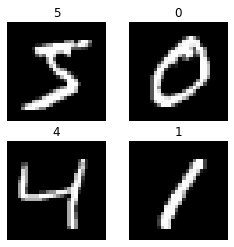

In [3]:
plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title(y_train[i])

In [4]:
x_train.max()

255

## 3. Prepare Data

การเตรียมข้อมูลให้สามารถใช้ในการสร้างโมเดลได้ เนื่องจากโมเดล CNN รองรับ Input เป็นอาเรย์ 3 มิติ จึงต้องทำการเพิ่มอีก 1 มิติให้กับภาพที่เป็น 2 มิติ อีกทั้งทำ Range Normalization ให้ค่า Pixel จากเดิมมีค่า [0,255] ให้เป็น [0,1] แทน ซึ่งเหมาะกับการคำนวน Gradient มากกว่า 

ส่วนข้อมูล Output เดิมเป็น Label Encoding ที่ใช้เลข 0-9 แทนตัวเลข 0-9 จะถูกแปลงเป็น One-Hot Encoding ด้วยฟังก์ชัน [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) เพื่อให้การคำนวณ Loss Function ทำได้ง่าย

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## 4. Train CNN model

เริ่มต้นจากการกำหนด Hyperparameter ของ CNN โมเดล โดยให้มี Convolutional Layer ที่มี Kernel ขนาด 3x3 และมี ReLU เป็น Activation Function ตามด้วย Max Pooling Layer ที่มี Window Size ขนาด 2x2 จำนวน 2 ชุด โดยมีจำนวน Filters เป็น 32 และ 64 ตามลำดับ แล้วจึงตามด้วย Flatten Layer เพื่อแปลงข้อมูลเป็นอาเรย์ 1 มิติ มี Dropout Layer ที่ความน่าจะเป็น 0.5 ในการป้องกันปัญหา Overfitting ส่วน Output Layer มี 10 units เพราะมี 10 ประเภท และใช้ Softmax เป็น Activation Function  

กำหนดให้ Loss Function เป็น Categorical Cross-Entropy (CE) $$ CE = -\sum_{i=1}^n y_i \log \hat{y}_i $$ โดย $n$ เป็นจำนวนตัวอย่าง, $y_i$ เป็นประเภทของตัวอย่าง $i$, $\hat{y}_i$ เป็นประเภทที่โมเดลทำนายของตัวอย่าง $i$ แล้วใช้อัลกอริทึม Adam เป็น Optimization Method และประเมินโมเดลด้วยความแม่นยำ (Accuracy)

In [6]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Sanity Check: ใช้ฟังก์ชัน [`summary`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) พิมพ์โครงสร้างของโมเดล และใช้ฟังก์ชัน [`plot_model`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) แสดงโครงสร้างของโมเดล

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

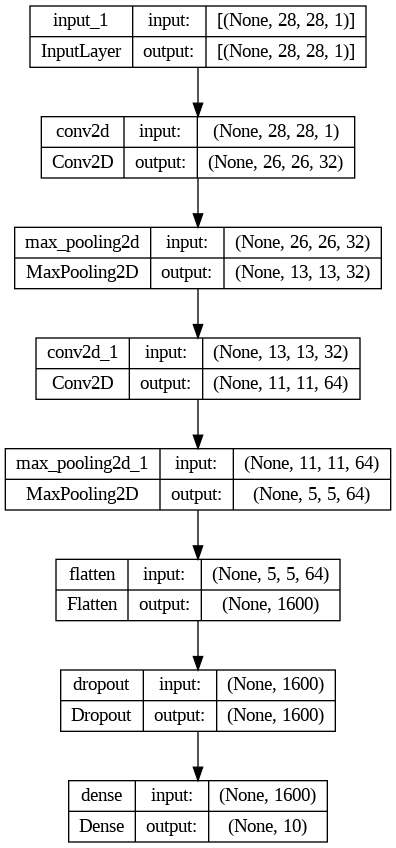

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

ทำการสร้างโมเดลโดยเรียกฟังก์ชัน [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) โดยกำหนดจำนวน epoch เป็น 10 รอบ และขนาด batch เป็น 128 ตัวอย่าง และแบ่งข้อมูล Trainin Data ใช้เป็น Validation Set ร้อยละ 10

In [9]:
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 8s 10ms/step - loss: 0.3697 - accuracy: 0.8873 - val_loss: 0.0863 - val_accuracy: 0.9767
Epoch 2/10
422/422 [==============================] - 4s 9ms/step - loss: 0.1122 - accuracy: 0.9653 - val_loss: 0.0573 - val_accuracy: 0.9833
Epoch 3/10
422/422 [==============================] - 5s 11ms/step - loss: 0.0863 - accuracy: 0.9743 - val_loss: 0.0476 - val_accuracy: 0.9877
Epoch 4/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0715 - accuracy: 0.9771 - val_loss: 0.0401 - val_accuracy: 0.9893
Epoch 5/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 6/10
422/422 [==============================] - 4s 10ms/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.0385 - val_accuracy: 0.9898
Epoch 7/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0522 - accuracy: 0.9836 - val_loss: 0.0343 - val_accuracy: 0.9907
Epo

## 5. Model Evaluation

ทำการทดสอบโมเดลโดยลองทำนายภาพในชุดข้อมูลทดสอบ และคำนวณค่าความแม่นยำ

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print('Test Accuracy: %.2f' % (score[1]*100))

Test loss: 0.027546068653464317
Test Accuracy: 99.01


-----